# Portfolio Analyzer

**Author:** Yusuf Ardahan Dogru  
**Date:** December 2025  
**Purpose:** Analyze multi-asset portfolios using Modern Portfolio Theory

## Overview
This notebook explores implementations and outcomes of portfolio optimization techniques that the author is curious about; including:
- Risk-return analysis
- Minimum variance optimization
- Sharpe ratio maximization

### Library Imports

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Style of Visualization

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Stock and ETF tickers

In [23]:
tickers = [
    # Individual stocks (play around with different stocks)
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', # 4 of the Magnificient 7
    'JPM', 'BAC',                    # finance/banking giants
    'WMT', 'AMZN',                   # retail giants ( + 1 Magnif 7)
    'JNJ', 'UNH',                    # healthcare
    'XOM', 'CVX',                    # oil
    
    # Strategic ETFs
    'SCHG',  # Growth
    'SPMO',  # Momentum
    'SMH',   # Semiconductors
    
    # Benchmarks
    'SPY',   # S&P 500
    'AGG'    # Bonds (consider for diversification)
]

### Get ticker data using yf

In [24]:
start_date = '2022-12-01'
end_date = '2024-12-01'

# auto_adjust=True => modifies historical stock prices so that stock splits and dividends do not artificially distort returns
# progress=False => this just removes the progress bar, just a visual setting
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)  


if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data['Close'].copy()
else:
    data = raw_data.copy()

print(f"Data shape: {data.shape}")
print(f"Date range: From {data.index[0].date()} to {data.index[-1].date()}")

Data shape: (502, 17)
Date range: From 2022-12-01 to 2024-11-29


### Handle Missing Values

In [25]:
if (data.isnull().sum()).sum() > 0:
    print(f"\nMissing values per stock:")
    print(data.isnull().sum())
    data = data.ffill()  
# ffill => forward fill => replace with last/preceding val

if len(data) < 100:
    print(f"Warning: Only {len(data)} days of data available")

In [26]:
returns = data.pct_change().dropna()
#pct_change is a pandas Dataframe method, computes: (current_value - previous_value) / previous_value for each column, row by row

print("Daily returns calculated!")
print(f"Shape: {returns.shape}")
print(f"\nSample returns:")
print(returns.head(1))

# Calculate key metrics
annual_returns = returns.mean() * 252  # 252 trading days per year
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_returns / annual_volatility

# Create summary DataFrame
metrics_df = pd.DataFrame({
    'Annual Return (%)': (annual_returns * 100).round(2),
    'Volatility (%)': (annual_volatility * 100).round(2),
    'Sharpe Ratio': sharpe_ratio.round(3)
}).sort_values('Sharpe Ratio', ascending=False)

print("\n" + "="*60)
print("PORTFOLIO METRICS SUMMARY")
print("="*60)
print(metrics_df)

Daily returns calculated!
Shape: (501, 17)

Sample returns:
Ticker          AAPL       AGG      AMZN       BAC    CVX     GOOGL       JNJ  \
Date                                                                            
2022-12-02 -0.003371  0.004146 -0.014346 -0.012859 -0.008 -0.005446  0.000783   

Ticker           JPM      MSFT      NVDA      SCHG       SMH      SPMO  \
Date                                                                     
2022-12-02 -0.007927  0.001296 -0.015115 -0.002962 -0.013744  0.001365   

Ticker           SPY       UNH       WMT       XOM  
Date                                                
2022-12-02 -0.001153  0.001681 -0.000978 -0.008484  

PORTFOLIO METRICS SUMMARY
        Annual Return (%)  Volatility (%)  Sharpe Ratio
Ticker                                                 
NVDA               118.09           51.32         2.301
WMT                 32.67           16.69         1.958
SCHG                32.44           17.58         1.846
SPMO   

### Check Correlations of Stock With Each Other

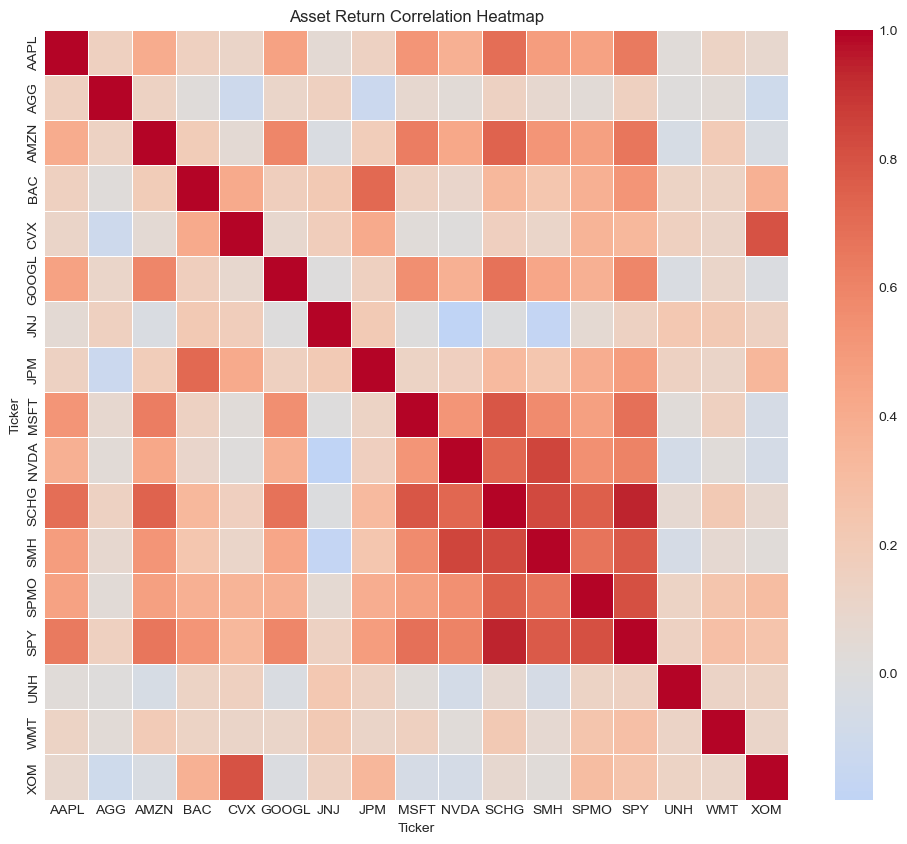

In [27]:
corr_matrix = returns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Asset Return Correlation Heatmap')
plt.show()

## Construct a fair portfolio (equal allocation in the porfolio for each ticker)

In [8]:
riskFreeRate = 0.04 # T-bills

num_assets = returns.shape[1] #num of stock tickers
equal_weights = np.array([1 / num_assets] * num_assets) #equal weights that add upto one

portfolio_returns_fair = returns @ equal_weights # daily returns of fairly allocated portfolio ( 1 / numStocks)

portfolio_vol_fair = portfolio_returns_fair.std() * np.sqrt(252)  # avg daily standard deviation * 252 for annualized volatility
portfolio_return_fair = portfolio_returns_fair.mean() * 252 # avg daily return * 252 to annualize
portfolio_sharpe_fair = portfolio_return_fair / portfolio_vol_fair

## Optimize Fair Portfolio 

In [22]:
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix.values @ weights)

# sum of weights must be equal to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

#each weight is between 0 and 1; a percentage of the portfolio
bounds = tuple((0, 1) for _ in range(num_assets))

from scipy.optimize import minimize

initial_weights = equal_weights

# minimize portfolio volatility using initial weights according to SLSQP method with bounds within 0 and 1 and the constraint above
opt_result = minimize(
    portfolio_volatility,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = opt_result.x
print(opt_weights)

[1.17920841e-02 0.00000000e+00 3.76760255e-18 1.21528707e-02
 4.95153113e-03 7.94178091e-18 6.95244643e-18 2.58898388e-01
 0.00000000e+00 1.91722540e-02 0.00000000e+00 0.00000000e+00
 3.49496582e-01 8.62458703e-02 1.76506474e-01 8.07839457e-02]


In [10]:
portfolio_returns_opt = returns @ opt_weights

portfolio_vol_opt = portfolio_returns_opt.std() * np.sqrt(252)
portfolio_return_opt = portfolio_returns_opt.mean() * 252
portfolio_sharpe_opt = portfolio_return_opt / portfolio_vol_opt

### Risk - Return Results

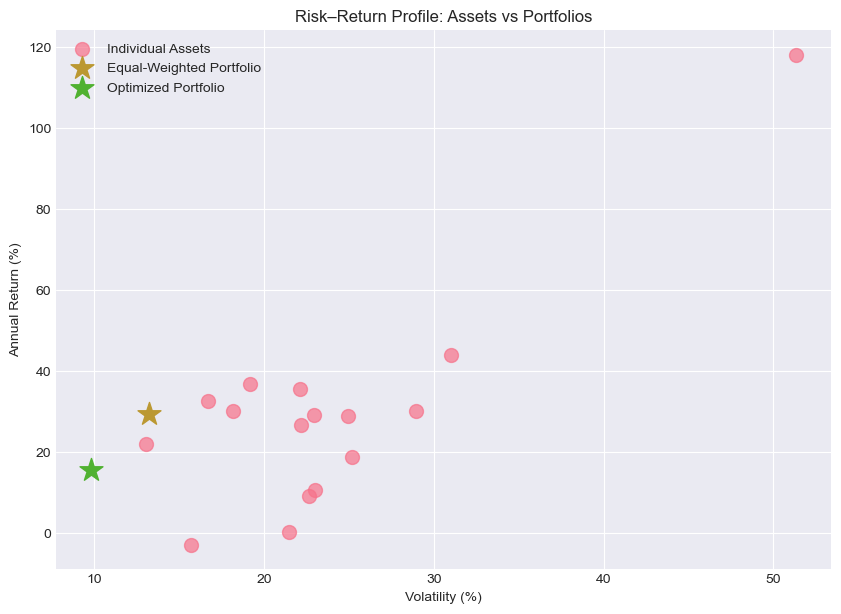

In [11]:
plt.figure(figsize=(10, 7))

plt.scatter(
    annual_volatility * 100,
    annual_returns * 100,
    s=100,
    alpha=0.7,
    label='Individual Assets'
)

plt.scatter(
    portfolio_vol_fair * 100,
    portfolio_return_fair * 100,
    marker='*',
    s=300,
    label='Equal-Weighted Portfolio'
)

plt.scatter(
    portfolio_vol_opt * 100,
    portfolio_return_opt * 100,
    marker='*',
    s=300,
    label='Optimized Portfolio'
)

plt.xlabel('Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.title('Risk–Return Profile: Assets vs Portfolios')
plt.legend()
plt.show()


### Rolling Volatility

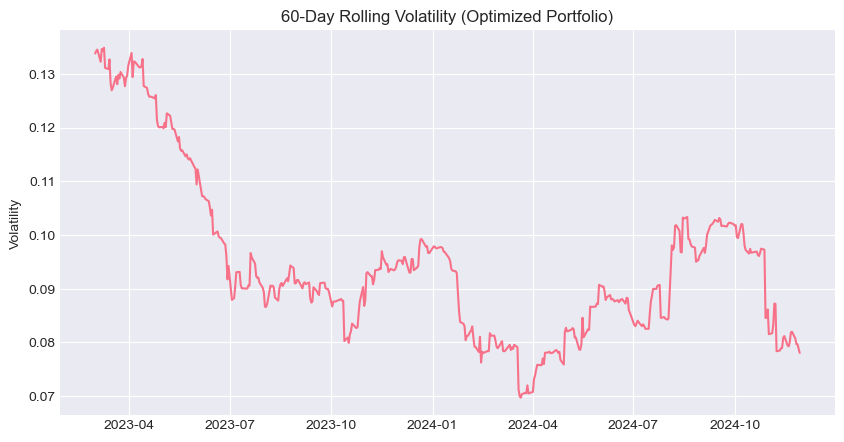

In [12]:
rolling_vol = portfolio_returns_opt.rolling(60).std() * np.sqrt(252)

plt.figure(figsize=(10, 5))
plt.plot(rolling_vol)
plt.title('60-Day Rolling Volatility (Optimized Portfolio)')
plt.ylabel('Volatility')
plt.show()